# Prova Final - Machine Learning

**Nome do aluno**: Eduardo Mendes Vaz

Você deve submeter o trabalho via Blackboard. É de sua responsabilidade garantir que o arquivo correto foi enviado.

Se você precisou adicionar arquivos extras à essa prova, assegure-se de que você os está enviando também.

A prova é individual e com consulta. Faça o seu trabalho de maneira ética! Se você recebeu ajuda de sistemas de apoio inteligentes (por exemplo, ChatGPT, Bard, CoPilot, etc) DECLARE CLARAMENTE ONDE VOCÊ RECEBEU AJUDA para não configurar plágio (definido como "declarar como próprio o trabalho construido por outrem - neste caso um sistema computacional")

In [215]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

# Contexto do problema

Vamos trabalhar com um *dataset* de empréstimos bancários (https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset). A tarefa é prefer se uma pessoa será aprovada ou rejeitada para um empréstimo (coluna *loan_status*).

In [216]:
data = pd.read_csv('loan_approval_dataset.csv').set_index('loan_id').apply(
    lambda x: x.astype('float64')
    if x.dtype == 'int64' else x.astype('category')
    if x.dtype == 'object' else x,
    axis=0)

In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   no_of_dependents          4269 non-null   float64 
 1   education                 4269 non-null   category
 2   self_employed             4269 non-null   category
 3   income_annum              4269 non-null   float64 
 4   loan_amount               4269 non-null   float64 
 5   loan_term                 4269 non-null   float64 
 6   cibil_score               4269 non-null   float64 
 7   residential_assets_value  4269 non-null   float64 
 8   commercial_assets_value   4269 non-null   float64 
 9   luxury_assets_value       4269 non-null   float64 
 10  bank_asset_value          4269 non-null   float64 
 11  loan_status               4269 non-null   category
dtypes: category(3), float64(9)
memory usage: 346.4 KB


In [218]:
data.select_dtypes(include='category').describe().transpose()

,count,unique,top,freq
education,4269,2,Graduate,2144
self_employed,4269,2,Yes,2150
loan_status,4269,2,Approved,2656


In [219]:
data.select_dtypes(include='float64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,4269.0,2.498712e+00,1.695910e+00,0.0,1.0,3.0,4.0,5.0
income_annum,4269.0,5.059124e+06,2.806840e+06,200000.0,2700000.0,5100000.0,7500000.0,9900000.0
loan_amount,4269.0,1.513345e+07,9.043363e+06,300000.0,7700000.0,14500000.0,21500000.0,39500000.0
loan_term,4269.0,1.090045e+01,5.709187e+00,2.0,6.0,10.0,16.0,20.0
cibil_score,4269.0,5.999361e+02,1.724304e+02,300.0,453.0,600.0,748.0,900.0
residential_assets_value,4269.0,7.472617e+06,6.503637e+06,-100000.0,2200000.0,5600000.0,11300000.0,29100000.0
commercial_assets_value,4269.0,4.973155e+06,4.388966e+06,0.0,1300000.0,3700000.0,7600000.0,19400000.0
luxury_assets_value,4269.0,1.512631e+07,9.103754e+06,300000.0,7500000.0,14600000.0,21700000.0,39200000.0
bank_asset_value,4269.0,4.976692e+06,3.250185e+06,0.0,2300000.0,4600000.0,7100000.0,14700000.0


In [220]:
X = data.drop(columns=['loan_status'], axis=1)
y = data['loan_status']
y

loan_id
1       Approved
2       Rejected
3       Rejected
4       Rejected
5       Rejected
          ...   
4265    Rejected
4266    Approved
4267    Rejected
4268    Approved
4269    Approved
Name: loan_status, Length: 4269, dtype: category
Categories (2, object): ['Approved', 'Rejected']

In [221]:
# Y é composto de valores categóricos, então precisamos transformá-los em valores numéricos
from sklearn.preprocessing import LabelEncoder

# guarda y normal para usar depois
y_holder = y
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 1, 1, ..., 1, 0, 0])

In [222]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
)

**Questão 1** (0,5 pts): Qual o desempenho do classificador trivial neste problema?

In [223]:
y_holder.unique()

['Approved', 'Rejected']
Categories (2, object): ['Approved', 'Rejected']

Como podemos ver, nosso target é uma categoria **binária**, e portanto o desempenho do classificador trivial é o chute: 50% de acurácia.

**Questão 2** (1 pt): Construa uma pipeline de pré-processamento para esses dados, com a seguinte estrutura:

- Para as colunas numéricas, use um `StandardScaler()`
- Para as colunas categóricas, use um `OneHotEncoder(drop='if_binary')`

Treine o pré-processador nos dados de treinamento e transforme os mesmos.


In [224]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Seleciona as features numéricas e o Transformador
num_features = X.select_dtypes(include='float64').columns
num_transformer = StandardScaler()

# Seleciona as features categóricas e o Transformador
cat_features = X.select_dtypes(include='category').columns
cat_transformer = OneHotEncoder(drop='if_binary')

# Cria o Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ],
    sparse_threshold=0,
)

# Aplica o Column Transformer no X_train
X_train_processed = preprocessor.fit_transform(X_train)

In [225]:
X_test_processed = preprocessor.transform(X_test)

**Questão 3** (1,5 pts): Analise o desempenho de uma `LogisticRegression` neste problema através de uma curva ROC: plote a curva ROC e informe o valor da área sobre a curva.

In [226]:
from sklearn.linear_model import LogisticRegression

# Treina o modelo
model = LogisticRegression(random_state=42)
model.fit(X_train_processed, y_train)  

# Faz a predição
y_hat = model.predict(X_test_processed)

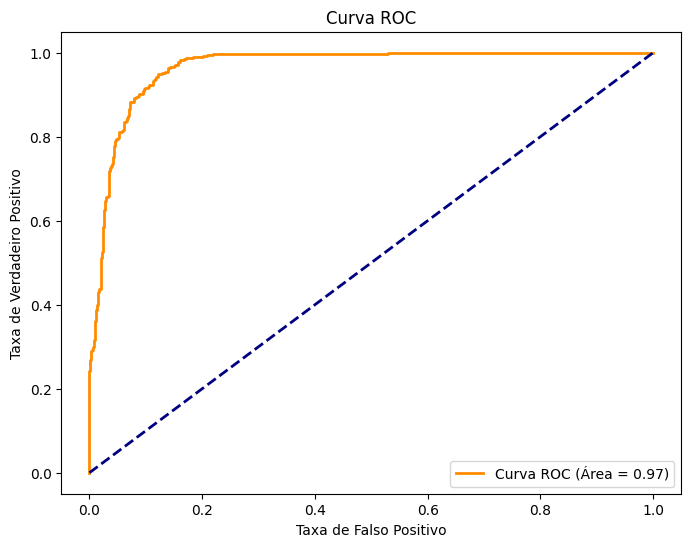

In [227]:
# ESSE CÓDIGO FOI FEITO NOS NOTEBOOKS DA MATÉRIA DE MACHINE LEARNING
# COM AUXÍLIO DO CHATGPT
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Calcular a probabilidade da classe positiva para os pontos de dados no conjunto de teste
y_prob = model.predict_proba(X_test_processed)[:, 1]

# Plotar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (Área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

**Questão 4** (1,0 pt): Repita a questão 3 mas para uma `RandomForestClassifier`, e compare os dois classificadores.

In [228]:
from sklearn.ensemble import RandomForestClassifier

# Treina o modelo
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train_processed, y_train)

# Faz a predição
y_hat = model.predict(X_test_processed)

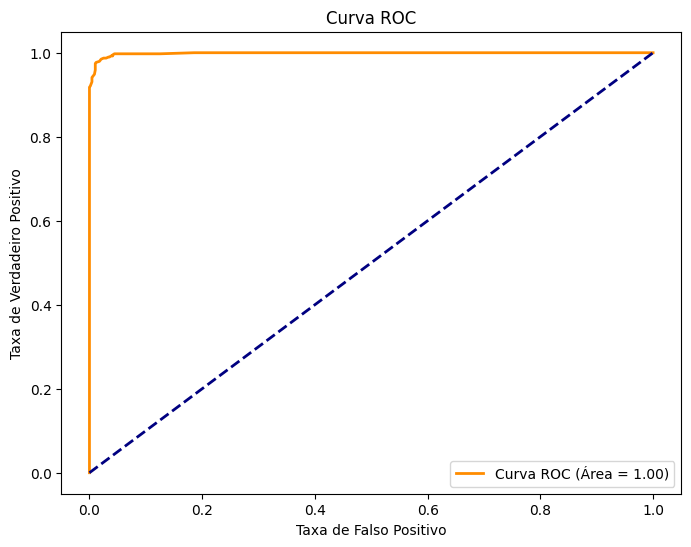

In [229]:
# ESSE CÓDIGO FOI FEITO NOS NOTEBOOKS DA MATÉRIA DE MACHINE LEARNING
# COM AUXÍLIO DO CHATGPT
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Calcular a probabilidade da classe positiva para os pontos de dados no conjunto de teste
y_prob = model.predict_proba(X_test_processed)[:, 1]

# Plotar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (Área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## Comparação

Somente a partir da curva ROC dos dois modelos, podemos perceber que o modelo RandomForest conseguiu perfeitamente prever os dados, enquanto o LogisticRegression teve um desempenho quase perfeito, com as áreas das Curvas ROC sendo 1 e 0.97 respectivamente.

**Questão 5**: 

a) (1,0 pts) Faça o *clustering* do dataset de treinamento pré-processado com `KMeans`, com 3 clusters, e obtenha os *labels* de cada amostra. Guarde estes labels em uma variável `cluster`

In [230]:
# KMeans clustering in the training data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_processed, y_train)

kmeans.predict(X_train_processed)
cluster = kmeans.labels_

/home/eduardo/Desktop/machine-learning/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


b) (0,5 pts) Agora use o código abaixo para visualizar o resultado do processo de clustering do ponto de vista de cada *feature*. Construa uma explicação, em suas palavras, sobre a natureza de cada cluster (e.g. "cluster 0 são os clientes de tal jeito, etc")

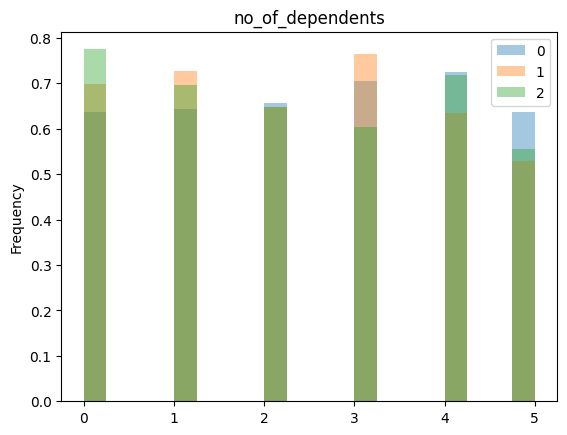

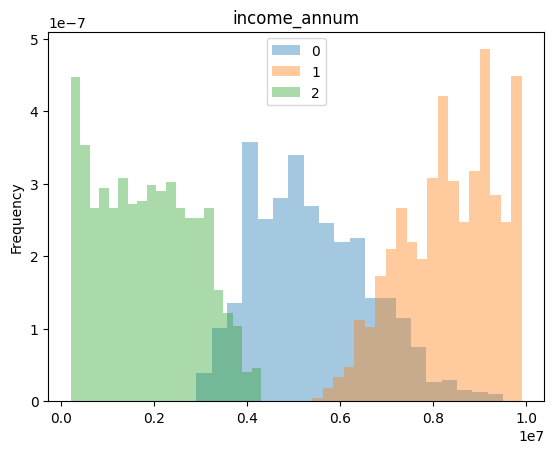

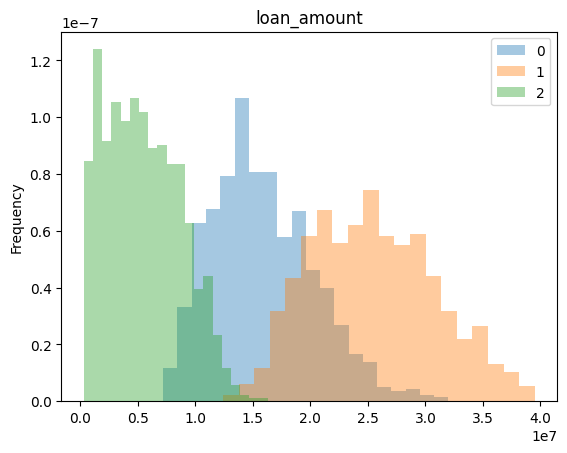

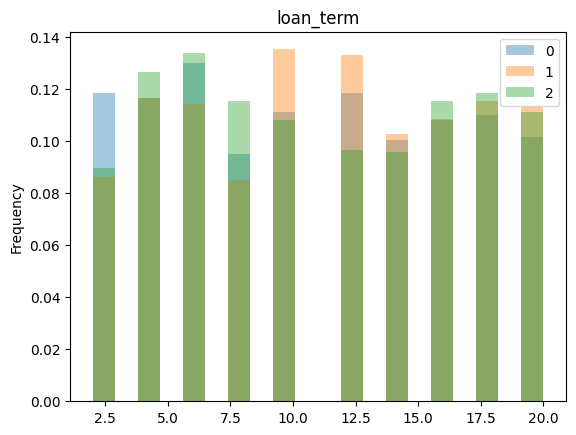

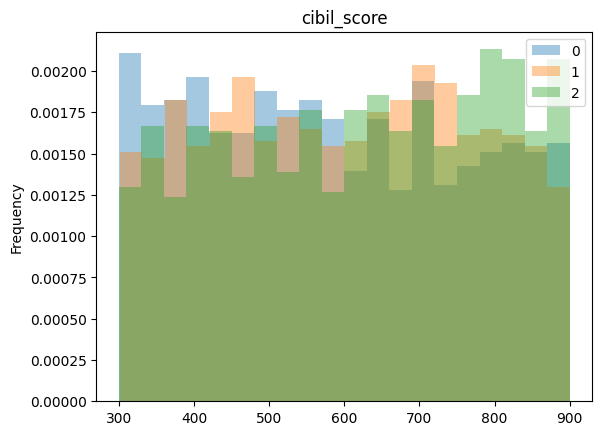

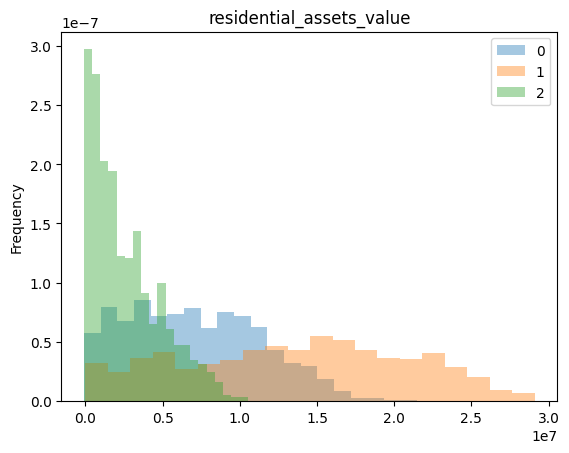

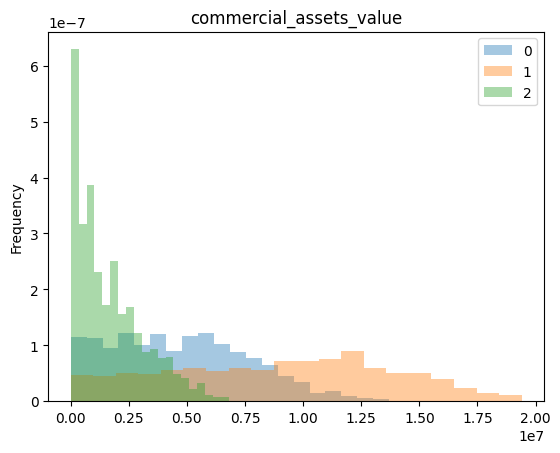

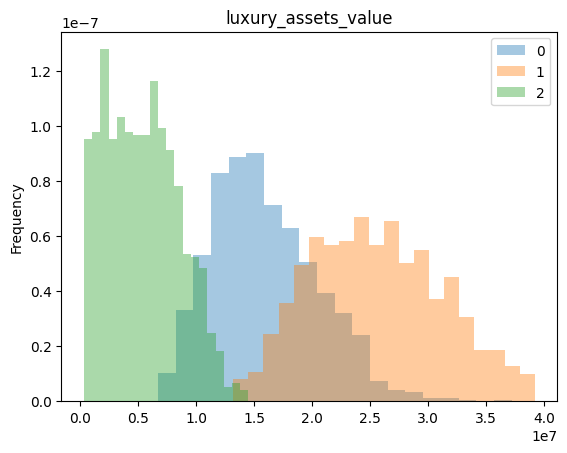

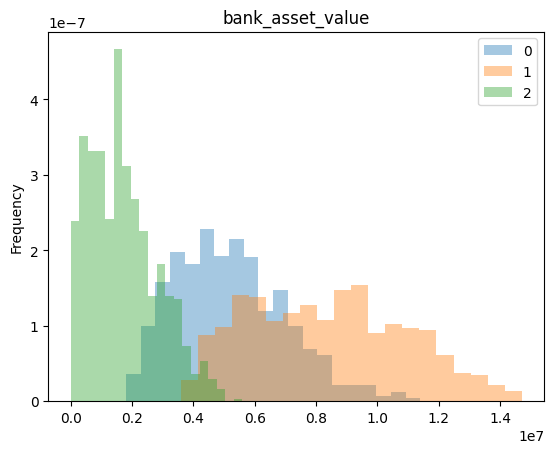

<Figure size 640x480 with 0 Axes>

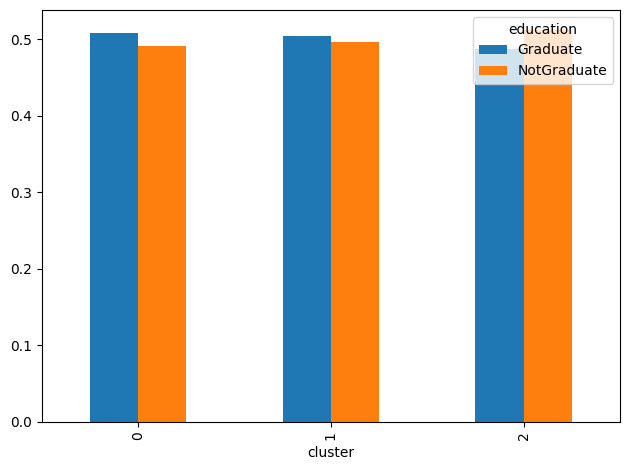

<Figure size 640x480 with 0 Axes>

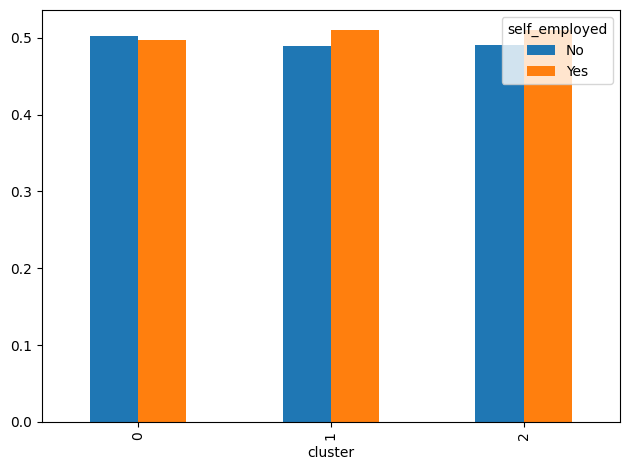

In [231]:
X_train_cluster = X_train.copy()
X_train_cluster['cluster'] = cluster

for column in X_train.select_dtypes('number').columns:
    plt.figure()
    X_train_cluster.groupby('cluster', observed=True)[column].plot.hist(
        bins=20, alpha=0.4, density=True)
    plt.title(column)
    plt.legend()
    plt.show()

for column in X_train.select_dtypes('category').columns:
    plt.figure()
    X_train_cluster.groupby('cluster', observed=True)[column].value_counts(
        normalize=True).unstack().plot.bar()
    plt.tight_layout()
    plt.show()

In [232]:
# Count the number of observations per cluster
X_train_cluster['cluster'].value_counts()

cluster
0    1170
2    1079
1     952
Name: count, dtype: int64

## Análise

Apesar de algumas visualizações estarem mais "misturadas" e menos interpretáveis que as outras, a partir das features "income_annum", "loan_ammount", "residential_assets_value", "comercial_assets_value", "luxury_assets_value" e "bank_asset_value" e o contexto do problema, um dataset que contém informações significativas para determinar a eligibilidade de um empréstimo bancário, podemos perceber que os 3 clusters gerados são correspondentes a **situações financeiras**, sendo os clusters em ordem **crescente** de situação financeira (primeiro, pior situação financeira, terceiro, melhor situação financeira) são 2, 0 e 1. 

As features mencionadas são as que mais facilmente permitem essa visualização: tem formatos claros de "montinhos", ou nossas classes bem definidas, e a ordem 2, 0 e 1 se repete sempre com os valores correspondentes à essa ordem. O salário anual, o valor do empréstimo requisitado, os valores dos pertences em suas diferentes categorias, todos demonstram essa ordem de situações financeiras.

Pontos importantes: Apesar da minha hipótese inicial ser que seria possível demonstrar isso mais ainda ao verificar **a quantidade de indivíduos por cluster**, presumindo que o cluster 2 teria mais pessoas e assim por diante, ao fazer essa verificação (célula acima) podemos ver que esse dataset é bem diverso, e a distribuição é equilibrada de indivíduos por classe. Outra observação interessante é que apesar da diferença monetária, as features "education" e "self_employed" mostram que as relações de educação e estar ou não empregado pouco influenciam esse dataset, visto que todas as 3 classes tem porcentagens similares dessas features.

**Questão 6**

a) (1,0 pt): Use PCA para obter duas componentes principais dos seus dados, e visualize-as em um *scatter plot*.

In [233]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_processed)

X_train_pca = pca.transform(X_train_processed)

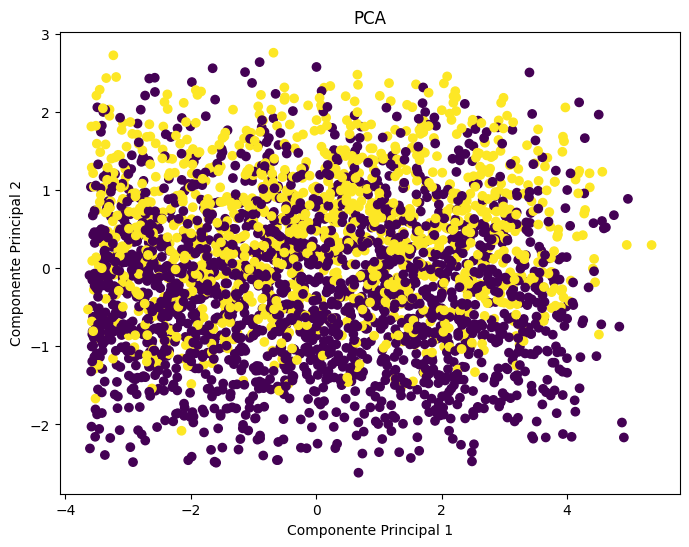

In [234]:
# Esse código foi gerado pelo COPILOT

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA')
plt.show()

b) (0,5 pts): Analise os vetores de direção principal (atributo `components_` da PCA) e escreva qual o significado de cada uma das duas primeiras direções principais. Por exemplo, se a feature *income_annum* tem alta magnitude em um vetor de direção principal, é porque essa feature importa bastante neste vetor.

In [235]:
pca.components_

array([[-0.00175599,  0.4600361 ,  0.4404931 ,  0.01117968, -0.02238446,
         0.3355281 ,  0.33861575,  0.43930364,  0.41648923, -0.00321817,
         0.00155653],
       [ 0.58717851, -0.00145765, -0.01138224, -0.58902653, -0.55435693,
         0.02331529, -0.01283261, -0.00137592, -0.00482191, -0.00935955,
        -0.00219697]])

0   no_of_dependents          4269 non-null   float64 
 1   education                 4269 non-null   category
 2   self_employed             4269 non-null   category
 3   income_annum              4269 non-null   float64 
 4   loan_amount               4269 non-null   float64 
 5   loan_term                 4269 non-null   float64 
 6   cibil_score               4269 non-null   float64 
 7   residential_assets_value  4269 non-null   float64 
 8   commercial_assets_value   4269 non-null   float64 
 9   luxury_assets_value       4269 non-null   float64 
 10  bank_asset_value   

## Análise

Analizando os vetores das duas primeiras direções principais, podemos ver que

- Para a primeira direção, as features **com maior magnitude**, ou seja, maior associação dessa feature com a componente, são: education, self_employed, loan_term, cibil_score, residential_assets, comercial_assets.
- Para a segunda direção, as features são: no_of_dependents, income_annum e loan_amount

A partir dessa análise, é possível inferir significados para as duas principais componentes.

A primeira componente aparenta ser **a situação financeira do cliente**, a partir das features como situação de emprego e estudo, o cibil score (valor de "crédito", que determina a confiança de um cliente a partir de seus empréstimos passados), seus bens residenciais e comerciais, todas essas informações condizentes com as analizadas para determinar a situação do cliente.

Já a segunda componente aparenta ser correspondente **aos valores mais impactantes no pagamento ou não do empréstimo**, com suas features de maior magnitude sendo o salário anual do cliente, o valor do empréstimo e o número de pessoas que dependem do cliente, todas essas informações cruciais nessa determinação. Um empréstimo absurdamente maior do que o salário de uma pessoa que tem 5 pessoas dependentes dela é lógicamente mais difícil de ser pago do que um empréstimo correspondente à 1 terço do salário de um cliente que não tem dependentes.

**Questão 7** (1,0 pt): Na PCA, no clustering por k-means e na SVM, a operação de `StandardScaler` é muito importante, explique por que.

### Resposta

Os três métodos mencionados, PCA, clustering e SVM **são altamente sensíveis à escala dos dados**, cada um por sua razão, geralmente por seu funcionamento depender da distância das amostras. 

PCA é sensível aos dados pois seu funcionamento consiste em identificar as direções ou componentes principais que maximizam a variância nos dados, ou seja, se as escalas das features forem muito diferentes, features com grandes valores númericos dominarão o resultado, por possuírem uma variância maior. 

O Clustering sofre com escala também, já que ao reunir os clusters, se os dados forem muito espalhados, o que pode ser considerado um cluster será inconsistente; Já após o escalonamento, os valores conseguem ser consistentemente agrupados, com suas distâncias sendo coerentes à escala dos dados.

A Técnica de SVM consiste em traçar uma "rua" nos dados, fazendo separações lineares. Idealmente, o modelo consegue criar **a maior "rua" possível**, separando muito mais eficientemente os dados de treino, para que quando for aplicado no conjunto de testes, a margem de erro seja menor. Obviamente que uma variância grande pode prejudicar essa delimitação da "rua", fazendo com que ela fique menor do que possível após o escalonamento.

**Questão 8** (1,0 pt): Crie um exemplo do seu cotidiano do Insper onde o efeito "wisdom of the crowds" aparece, e produz decisões melhores que as decisões individuais. Identifique neste exemplo o que seria o modelo forte (o "sábio") e o que seriam os modelos fracos (os "goiabas").

### Resposta

Um exemplo bom para entender o "wisdom of the crowds" seria a criação de um novo aplicativo do Insper, muito mais complexo e com muito mais funcionalidades do que o atual. D

igamos que esse app faz mil maravilhas, mas que para implementá-lo fosse necessário utilizar várias diferentes frameworks, sejam web, análise de dados, IA, Machine Learning etc, e esses frameworks estivessem em discussão, com a equipe de desenvolvimento pedindo para os integrantes do Insper, alunos e professores, para votarem nas frameworks a serem usadas para cada funcionalidade do app. 

Pedir para somente um professor do Insper, totalmente capaz de trabalhar na sua área com maestria, mas que é pouco habilidoso em outras áreas necessárias para criar o app seria pouco frutífero, já que ele é um expert na área dele. Já pedir para os alunos darem suas opiniões, alunos esses que estão começando suas carreiras na área da computação, e experimentam com diferentes frameworks, áreas de trabalho e tem diversas matérias de diversos conteúdos faz mais sentido, já que essa diversidade de conteúdos é mais importante **nesse caso** do que o conhecimento expert em somente uma área.

**Questão 9** (1,0 pt): Em sala de aula repetimos várias vezes o mantra "o inimigo do overfitting é a regularização". Explique o que isso significa, com suas palavras.

### Resposta

A técnica de regularização consiste em **limitar a complexidade de um modelo linear**. Esse objetivo é cumprido por meio da **utilização de uma métrica de erro regularizada**, que consiste na métrica de erro comum adicionada de um termo. Cada regularização tem seu termo com seus impactos específicos, mas todos os termos tem o efeito de **penalizar** modelos muito complexos e **priorizar** modelos mais simples, a medida que a perda é pouco relevante. Essa priorização e penalização evita overfitting justamente por favorecer modelos menos complexos, que são também menos propícios à overfitting.